In [ ]:
from google.colab import drive
drive.mount('Drive')

Mounted at Drive


In [ ]:
from PIL import Image 
from collections import Counter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re

# **Carregando Imagens**

In [ ]:
os.chdir('/content/Drive/MyDrive/PDI/Imagens') # Acessa o diretório da imagem
os.getcwd() # Retorna o diretório atual
os.listdir() # Lista os arquivos do diretório

['DancingInWater.jpg',
 'testpat.1k.color.tif',
 'Shapes.png',
 'fruits.jpg',
 'bruxa.png']

In [ ]:
image = Image.open('bruxa.png') # Abre a imagem
print('Mode: {0}'.format(image.mode)) # Recupera o espaço de cores utilizado pela imagem
print('Size: {0}'.format(image.size)) # Recupera o tamanho da imagem (pixels)

Mode: RGBA
Size: (464, 306)


Text(0.5, 1.0, 'Current Image')

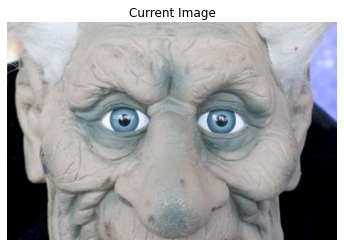

In [ ]:
plt.imshow(image) # Exibe a imagem
plt.axis('off')
plt.title('Current Image')

# **Separando em Canais**

Text(0.5, 1.0, 'Blue')

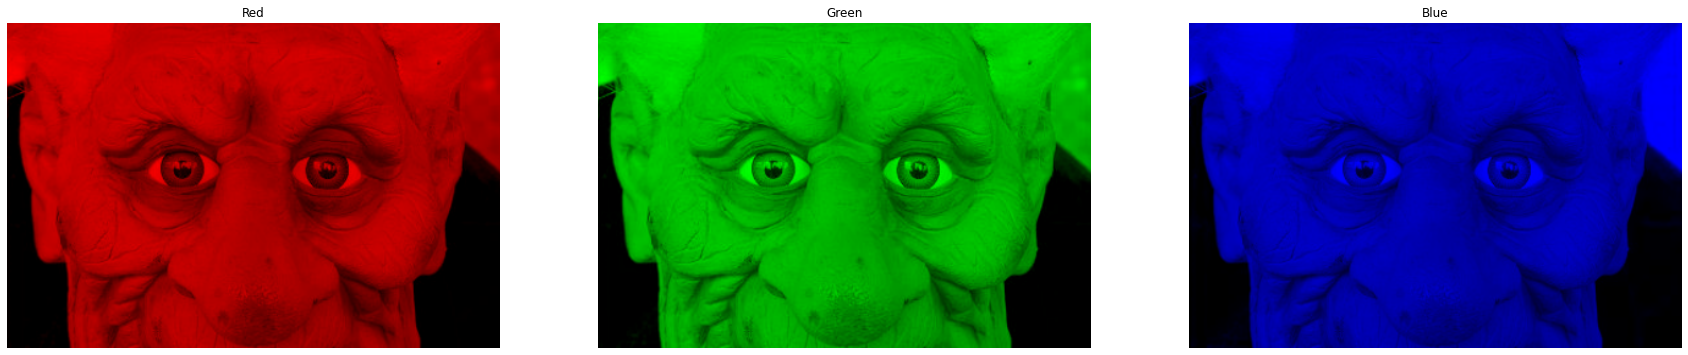

In [ ]:
fig = plt.figure(figsize=(30,10))

# Faço três cópias para cada canal
image_array_red = np.array(image)
image_array_green = np.array(image)
image_array_blue = np.array(image)

fig.add_subplot(1,3,1)

# Zero as componente VERDE e AZUL
image_array_red[:,:,1] *= 0
image_array_red[:,:,2] *= 0
plt.imshow(image_array_red)
plt.axis('off')
plt.title('Red')

fig.add_subplot(1,3,2)

# Zero as componentes VERMELHO e AZUL
image_array_green[:,:,0] *= 0
image_array_green[:,:,2] *= 0
plt.imshow(image_array_green)
plt.axis('off')
plt.title('Green')

fig.add_subplot(1,3,3)

# Zero as componentes VERMELHO e VERDE
image_array_blue[:,:,0] *= 0
image_array_blue[:,:,1] *= 0
plt.imshow(image_array_blue)
plt.axis('off')
plt.title('Blue')

# **RGB-YIQ-RGB**

In [ ]:
'''
LIMITES DO RGB
'''
def limiter(val):
  if val > 255:
    return 255
  elif val < 0:
    return 0
  
  return val

In [ ]:
'''
CONVERSÃO RGB -> YIQ
'''
def rgb_to_yiq(rgb):
  yiq = np.array(image,dtype=float)

  yiq[:,:,0] = (0.299)*rgb[:,:,0] + (0.587)*rgb[:,:,1] + (0.114)*rgb[:,:,2]
  yiq[:,:,1] = (0.596)*rgb[:,:,0] - (0.274)*rgb[:,:,1] - (0.322)*rgb[:,:,2]
  yiq[:,:,2] = (0.211)*rgb[:,:,0] - (0.523)*rgb[:,:,1] + (0.312)*rgb[:,:,2]

  return yiq

'''
CONVERSÃO YIQ -> RGB
'''
def yiq_to_rgb(yiq):
  rows, columns, components = np.shape(yiq)
  rgb = np.zeros((rows, columns, 3), dtype=int)

  for i in range(rows):
    for j in range(columns):
      rgb[i][j][0] = limiter(yiq[i][j][0] + (0.956)*yiq[i][j][1] + (0.621)*yiq[i][j][2])
      rgb[i][j][1] = limiter(yiq[i][j][0] - (0.272)*yiq[i][j][1] - (0.647)*yiq[i][j][2])
      rgb[i][j][2] = limiter(yiq[i][j][0] - (1.106)*yiq[i][j][1] + (1.703)*yiq[i][j][2])
  
  return rgb

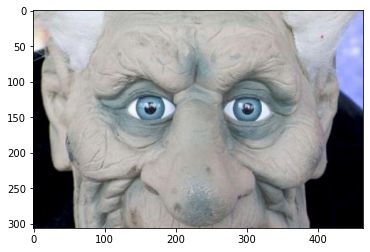

In [ ]:
rgb = np.array(image)
rgb = rgb_to_yiq(rgb)
rgb = yiq_to_rgb(rgb)

plt.imshow(rgb)

# **Negativo**

## **Negativo em RGB**

In [ ]:
'''
APLICAÇÃO DE NEGATIVO -> L-1-r
'''
def rgb_neg(image_arr):
  image_arr[:,:,0] = 255 - image_arr[:,:,0]
  image_arr[:,:,1] = 255 - image_arr[:,:,1]
  image_arr[:,:,2] = 255 - image_arr[:,:,2]

Text(0.5, 1.0, 'Negative')

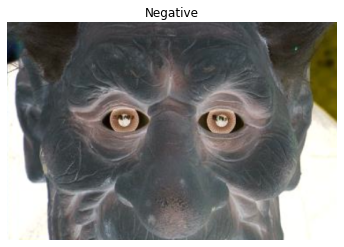

In [ ]:
image_arr = np.array(image)
rgb_neg(image_arr)

plt.imshow(image_arr)
plt.axis('off')
plt.title('Negative')

## **Negativo em YIQ**

In [ ]:
'''
APLICAÇÃO DE NEGATIVO -> L-1-r
'''
def yiq_neg(rgb):
  yiq = rgb_to_yiq(rgb)

  yiq[:,:,0] = 255 - yiq[:,:,0]

  return yiq_to_rgb(yiq)

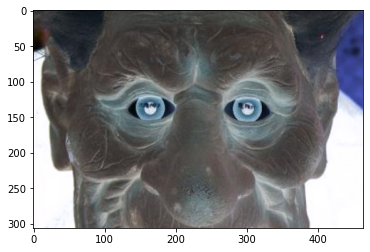

In [ ]:
rgb = np.array(image)

rgb = yiq_neg(rgb)

plt.imshow(rgb)

# **Filtro**

In [ ]:
def zero_extension(image_arr, r_filter, c_filter, pivot_row, pivot_column):
  rows, columns, components = np.shape(image_arr)
  
  zero_row_add = (r_filter - 1)//2
  zero_column_add = (c_filter - 1)//2

  '''
    Descobrimos qual das componentes do pivô possui maior relevância
  '''
  pivot_row -= zero_row_add
  pivot_column -= zero_column_add

  if pivot_row < 0:
    pivot_row *= -1
  elif pivot_column < 0:
    pivot_column *= -1

  # Recuperamos qual o maior valor de relevância (linha ou coluna do pivô)
  result = max(pivot_row, pivot_column)

  '''
     Adicionamos ao número de linhas e colunas o valor de relevância que a posição do pivô possui
     na adição de linhas e colunas com zero
  '''
  zero_row_add += result
  zero_column_add += result

  '''
    rows = número de linhas na matriz original
    zero_column_add = número de colunas a serem adicionadas
    zero_row_add = número de linhas a serem adicionadas
    columns + zero_column_add * 2 = número de colunas na matriz original + (número de colunas a serem adicionadas * 2), multiplicamos por 2 pois é em cima e em baixo
  '''
  zero_column = np.zeros((rows,zero_column_add))  # (COLUNA) 
  zero_line = np.zeros((zero_row_add, columns + zero_column_add * 2))# (LINHA) 

  extended_image_arr = np.zeros((rows + zero_row_add*2, columns + zero_column_add*2, 3))
                
  image_arr_red = np.append(zero_column, image_arr[:,:,0], axis = 1) # coluna antes
  image_arr_red = np.append(image_arr_red, zero_column, axis = 1) # colunas depois

  image_arr_green = np.append(zero_column, image_arr[:,:,1], axis = 1) # coluna antes
  image_arr_green = np.append(image_arr_green, zero_column, axis = 1) # colunas depois

  image_arr_blue = np.append(zero_column, image_arr[:,:,2], axis = 1) # coluna antes
  image_arr_blue = np.append(image_arr_blue, zero_column, axis = 1) # colunas depois  

  image_arr_red = np.append(zero_line, image_arr_red, axis = 0) # linha antes
  image_arr_red = np.append(image_arr_red, zero_line, axis = 0) # linha depois

  image_arr_green = np.append(zero_line, image_arr_green, axis = 0) # linha antes
  image_arr_green = np.append(image_arr_green, zero_line, axis = 0) # linha depois

  image_arr_blue = np.append(zero_line, image_arr_blue, axis = 0) # linha antes
  image_arr_blue = np.append(image_arr_blue, zero_line, axis = 0) # linha depois

  extended_image_arr[:,:,0] = image_arr_red
  extended_image_arr[:,:,1] = image_arr_green
  extended_image_arr[:,:,2] = image_arr_blue

  return (extended_image_arr, zero_row_add, zero_column_add)

In [ ]:
'''TESTES
arr = np.array([[1,1,2,3,4], [1,1,2,3,4], [1,1,2,3,4], [1,1,2,3,4], [1,1,2,3,4]])

print(arr)

arr = zero_extension(arr,  5,3,0,0)
print()

print(arr)
'''

[[1 1 2 3 4]
 [1 1 2 3 4]
 [1 1 2 3 4]
 [1 1 2 3 4]
 [1 1 2 3 4]]

(array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 1., 2., 3., 4., 0., 0., 0.],
       [0., 0., 0., 1., 1., 2., 3., 4., 0., 0., 0.],
       [0., 0., 0., 1., 1., 2., 3., 4., 0., 0., 0.],
       [0., 0., 0., 1., 1., 2., 3., 4., 0., 0., 0.],
       [0., 0., 0., 1., 1., 2., 3., 4., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]), 4, 3)


## **Filtro da Mediana**

In [ ]:
'''
FILTRO DA MEDIANA -> Redução de Noise
'''

def median_filter(image_array, r_filter, c_filter, pivot_row, pivot_column):
  result_image = image_array.copy()
  
  image_array, rows_add, columns_add = zero_extension(image_array, r_filter, c_filter, pivot_row, pivot_column)
  rows, columns, components = np.shape(image_array)
  
  for i in range(rows_add, rows - rows_add):
    for j in range(columns_add, columns - columns_add):
      filter_shape = [[],[],[]]
      
      for m in range(i - pivot_row, i + (r_filter - pivot_row)):
        for n in range(j - pivot_column, j + (c_filter - pivot_column)):
          filter_shape[0].append(image_array[m][n][0])
          filter_shape[1].append(image_array[m][n][1])
          filter_shape[2].append(image_array[m][n][2])
      
      filter_shape[0].sort()
      filter_shape[1].sort()
      filter_shape[2].sort()
      result_image[i - rows_add][j - columns_add][0] = filter_shape[0][len(filter_shape[0])//2]
      result_image[i - rows_add][j - columns_add][1] = filter_shape[1][len(filter_shape[1])//2]
      result_image[i - rows_add][j - columns_add][2] = filter_shape[2][len(filter_shape[2])//2]
  
  return result_image

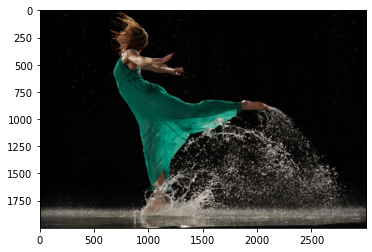

In [ ]:
image_array = np.array(image)

image_array = median_filter(image_array, 9 ,9 , 4, 4)

plt.imshow(image_array)

## **Filtro da Média**

In [ ]:
def mean_filter(image_array, filter, pivot, offset):
  result_image = image_array.copy()

  r_filter, c_filter = np.shape(filter)
  pivot_row = pivot['row']
  pivot_column = pivot['column']
  
  image_array, rows_add, columns_add = zero_extension(image_array, r_filter, c_filter, pivot_row, pivot_column)
  rows, columns, components = np.shape(image_array)
  
  for i in range(rows_add, rows - rows_add):
    for j in range(columns_add, columns - columns_add):
      result_red = 0.0
      result_green = 0.0
      result_blue = 0.0
      
      for m in range(i - pivot_row, i + (r_filter - pivot_row)):
        aux = m % r_filter

        for n in range(j - pivot_column, j + (c_filter - pivot_column)):
          result_red += image_array[m][n][0]*filter[aux][n % c_filter]
          result_green += image_array[m][n][1]*filter[aux][n % c_filter]
          result_blue += image_array[m][n][2]*filter[aux][n % c_filter]
      
      result_image[i - rows_add][j - columns_add][0] = limiter(result_red + offset)
      result_image[i - rows_add][j - columns_add][1] = limiter(result_green + offset)
      result_image[i - rows_add][j - columns_add][2] = limiter(result_blue + offset)
  
  return result_image

# **RGB-HSB-RGB**

In [ ]:
def rgb_to_hsb(image_arr):
  rows, columns, components = np.shape(image_arr)
  image_array = np.zeros((rows, columns, 3), dtype=float)

  for i in range(rows):
    for j in range(columns):
      R_color = image_arr[i][j][0]
      G_color = image_arr[i][j][1]
      B_color = image_arr[i][j][2]

      r = R_color/255
      g = G_color/255
      b = B_color/255

      c_max = max(r,g)
      c_max = max(c_max, b)

      c_min = min(r,g)
      c_min = min(c_min,b)

      delta = c_max - c_min

      H = -1
      if delta == 0:
        H = 0
      elif c_max == r:
        H = 60 * (((g - b)/delta)%6)
      elif c_max == g:
        H = 60 * (((b - r)/delta) + 2)
      elif c_max == b:
        H = 60 * (((r - g)/delta) + 4)
      
      S = -1
      if c_max == 0:
        S = 0
      else:        
        S = delta/c_max

      B = c_max

      image_array[i][j][0] = H
      image_array[i][j][1] = S
      image_array[i][j][2] = B
  
  return image_array

In [ ]:
def hsb_to_rgb(image_arr):
  rows, columns, components = np.shape(image_arr)
  arr = np.zeros((rows, columns, 3), dtype=int)

  for i in range(rows):
    for j in range(columns):
      H = image_arr[i][j][0]
      S = image_arr[i][j][1]
      B = image_arr[i][j][2]

      c = B * S
      x = c * (1 - abs((H / 60)%2 - 1))
      m = B - c

      r = 0
      g = 0
      b = 0

      if H >= 0 and H < 60:
        r = c
        g = x
        b = 0

      elif H >= 60 and H < 120:
        r = x
        g = c
        b = 0

      elif H >= 120 and H < 180:
        r = 0
        g = c
        b = x

      elif H >= 180 and H < 240:
        r = 0
        g = x
        b = c

      elif H >= 240 and H < 300:
        r = x
        g = 0
        b = c

      elif H >= 300 and H < 360:
        r = c
        g = 0
        b = x

      arr[i][j][0] = (r + m)*255
      arr[i][j][1] = (g + m)*255
      arr[i][j][2] = (b + m)*255

  return arr

In [ ]:
def limiter_saturation(val):
  if val > 1:
    return 1
  elif val < 0:
    return 0
  
  return val

In [ ]:
def control_saturation(image_arr, saturation_add):
  rows, columns, components = np.shape(image_arr)
  image_arr_hsb = rgb_to_hsb(image_arr)

  for i in range(rows):
    for j in range(columns):
      image_arr_hsb[i][j][1] = limiter_saturation(image_arr_hsb[i][j][1] + saturation_add)
  
  return hsb_to_rgb(image_arr_hsb)

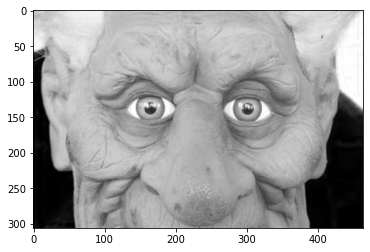

In [ ]:
image_arr = np.array(image)

image_arr = control_saturation(image_arr, -1.0)

plt.imshow(image_arr)

# **Sobel**

In [ ]:
def horizontal_sobel_filter(image_array, mask, offset):
  horizontal_sobel = mask
  result_image = image_array.copy()
  
  image_array, rows_add, columns_add = zero_extension(image_array, 3, 3, 1, 1)
  rows, columns, components = np.shape(image_array)
  
  for i in range(rows_add, rows - rows_add):
    for j in range(columns_add, columns - columns_add):
      result_red =  abs(image_array[i + 1][j - 1][0]*horizontal_sobel[2][0] + image_array[i + 1][j][0]*horizontal_sobel[2][1] + image_array[i + 1][j + 1][0]*horizontal_sobel[2][2] + image_array[i - 1][j - 1][0]*horizontal_sobel[0][0] + image_array[i - 1][j][0]*horizontal_sobel[0][1] + image_array[i - 1][j + 1][0]*horizontal_sobel[0][2])
      result_green =  abs(image_array[i + 1][j - 1][1]*horizontal_sobel[2][0] + image_array[i + 1][j][1]*horizontal_sobel[2][1] + image_array[i + 1][j + 1][1]*horizontal_sobel[2][2] + image_array[i - 1][j - 1][1]*horizontal_sobel[0][0] + image_array[i - 1][j][1]*horizontal_sobel[0][1] + image_array[i - 1][j + 1][1]*horizontal_sobel[0][2])
      result_blue =  abs(image_array[i + 1][j - 1][2]*horizontal_sobel[2][0] + image_array[i + 1][j][2]*horizontal_sobel[2][1] + image_array[i + 1][j + 1][2]*horizontal_sobel[2][2] + image_array[i - 1][j - 1][2]*horizontal_sobel[0][0] + image_array[i - 1][j][2]*horizontal_sobel[0][1] + image_array[i - 1][j + 1][2]*horizontal_sobel[0][2])

      result_image[i - rows_add][j - columns_add][0] = limiter(result_red + offset)
      result_image[i - rows_add][j - columns_add][1] = limiter(result_green + offset)
      result_image[i - rows_add][j - columns_add][2] = limiter(result_blue+ offset)
  
  return result_image

In [ ]:
def vertical_sobel_filter(image_array, mask, offset):
  vertical_sobel = mask
  result_image = image_array.copy()
  
  image_array, rows_add, columns_add = zero_extension(image_array, 3, 3, 1, 1)
  rows, columns, components = np.shape(image_array)
  
  for i in range(rows_add, rows - rows_add):
    for j in range(columns_add, columns - columns_add):
      result_red =  abs(image_array[i - 1][j + 1][0]*vertical_sobel[0][2] + image_array[i][j + 1][0]*vertical_sobel[1][2] + image_array[i + 1][j + 1][0]*vertical_sobel[2][2] + image_array[i - 1][j - 1][0]*vertical_sobel[0][0] + image_array[i][j - 1][0]*vertical_sobel[1][0] + image_array[i + 1][j - 1][0]*vertical_sobel[2][0])
      result_green =  abs(image_array[i - 1][j + 1][1]*vertical_sobel[0][2] + image_array[i][j + 1][1]*vertical_sobel[1][2] + image_array[i + 1][j + 1][1]*vertical_sobel[2][2] + image_array[i - 1][j - 1][1]*vertical_sobel[0][0] + image_array[i][j - 1][1]*vertical_sobel[1][0] + image_array[i + 1][j - 1][1]*vertical_sobel[2][0])
      result_blue =  abs(image_array[i - 1][j + 1][2]*vertical_sobel[0][2] + image_array[i][j + 1][2]*vertical_sobel[1][2] + image_array[i + 1][j + 1][2]*vertical_sobel[2][2] + image_array[i - 1][j - 1][2]*vertical_sobel[0][0] + image_array[i][j - 1][2]*vertical_sobel[1][0] + image_array[i + 1][j - 1][2]*vertical_sobel[2][0])

      result_image[i - rows_add][j - columns_add][0] = (result_red + offset)
      result_image[i - rows_add][j - columns_add][1] = (result_green + offset)
      result_image[i - rows_add][j - columns_add][2] = (result_blue + offset)
  
  return result_image

In [ ]:
def sobel_filter(image_array):
  result_image = image_array.copy()
  
  image_array, rows_add, columns_add = zero_extension(image_array, 3, 3, 1, 1)
  rows, columns, components = np.shape(image_array)
  
  for i in range(rows_add, rows - rows_add):
    for j in range(columns_add, columns - columns_add):
      result =  abs(image_array[i + 1][j - 1] + 2*image_array[i + 1][j] + image_array[i + 1][j + 1] - image_array[i - 1][j - 1] - 2*image_array[i - 1][j] - image_array[i - 1][j + 1])
      result +=  abs(image_array[i - 1][j + 1] + 2*image_array[i][j + 1] + image_array[i + 1][j + 1] - image_array[i - 1][j - 1] - 2*image_array[i][j - 1] - image_array[i + 1][j - 1])

      result_image[i - rows_add][j - columns_add] = result
  
  return result_image

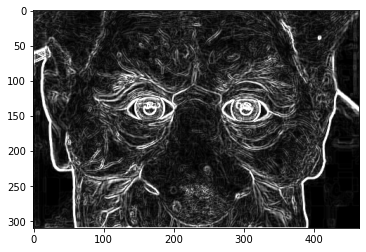

In [ ]:
image_arr = np.array(image)

image_arr = control_saturation(image_arr, -2.0)

image_arr = sobel_filter(image_arr)

plt.imshow(image_arr)

# **Expansão de Histograma**

In [ ]:
def equalization_histogram(image_array):
    rows, columns, components = np.shape(image_array)
    
    flat_image = image_array.flatten()
    flat_image.sort()

    L = 256

    counted = Counter(flat_image)

    keys = counted.keys()
    acc = {}
    eq_values = {}
    aux = 0


    for r in range(0, 256):
      if r == 0:
        pass
      
      else:
        aux += counted[str(r - 1)]
        acc[str(r)] = counted[str(r)] + aux

        print(aux)

        eq_values[str(r)] = (((L - 1) / (rows * columns)) * aux)


    print(eq_values)

t = [1,2,3,4]
for i in range(len(t)):
print(sum(t[0:i))

In [ ]:
def expansion_histogram(image_array):
  flat_image = image_array.flatten()
  flat_image.sort()

  L = 256

  r_max = flat_image[len(flat_image) - 1]
  r_min = flat_image[0]

  counted = Counter(flat_image)

  keys = counted.keys()

  values = {}

  for r in keys:
    
    values[r] = round(((counted[r] - r_min) / (r_max - r_min)) * (L - 1))

  print(f'Expansão: {values}')

  return flat_image

In [ ]:
expansion = Counter(expansion_histogram(image_arr))

Expansão: {0: 3108, 2: 829, 4: 2473, 6: 1834, 8: 2988, 10: 2502, 12: 2989, 14: 2656, 16: 2899, 18: 2710, 20: 2690, 22: 2534, 24: 2345, 26: 2333, 28: 2130, 30: 2065, 32: 2007, 34: 1842, 36: 1776, 38: 1629, 40: 1550, 42: 1399, 44: 1374, 46: 1290, 48: 1156, 50: 1137, 52: 1107, 54: 1055, 56: 951, 58: 900, 60: 865, 62: 811, 64: 739, 66: 724, 68: 651, 70: 635, 72: 589, 74: 553, 76: 523, 78: 479, 80: 492, 82: 446, 84: 437, 86: 408, 88: 411, 90: 351, 92: 363, 94: 351, 96: 305, 98: 297, 100: 293, 102: 287, 104: 272, 106: 252, 108: 226, 110: 244, 112: 256, 114: 210, 116: 212, 118: 206, 120: 187, 122: 196, 124: 196, 126: 183, 128: 150, 130: 141, 132: 147, 134: 147, 136: 145, 138: 132, 140: 133, 142: 133, 144: 129, 146: 123, 148: 108, 150: 107, 152: 103, 154: 108, 156: 90, 158: 95, 160: 97, 162: 90, 164: 85, 166: 83, 168: 81, 170: 77, 172: 78, 174: 66, 176: 66, 178: 65, 180: 63, 182: 66, 184: 55, 186: 57, 188: 60, 190: 50, 192: 46, 194: 54, 196: 49, 198: 41, 200: 57, 202: 39, 204: 46, 206: 50, 208

In [ ]:
print(counted.keys())

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219,

In [ ]:
print(counted.values())

dict_values([31464, 4503, 4943, 1912, 2512, 1414, 990, 826, 695, 617, 463, 369, 384, 324, 305, 284, 246, 214, 230, 183, 160, 179, 133, 119, 104, 132, 125, 127, 118, 117, 108, 142, 128, 100, 82, 117, 124, 91, 88, 102, 97, 101, 98, 104, 101, 103, 91, 103, 98, 83, 83, 83, 74, 61, 73, 73, 71, 88, 101, 118, 90, 137, 128, 132, 140, 146, 180, 162, 177, 207, 216, 227, 202, 235, 256, 253, 260, 289, 279, 314, 337, 340, 340, 430, 431, 426, 490, 488, 469, 516, 552, 512, 509, 558, 604, 575, 643, 635, 662, 632, 677, 703, 679, 772, 799, 787, 847, 863, 912, 965, 982, 1069, 1130, 1187, 1111, 1191, 1214, 1258, 1332, 1324, 1356, 1324, 1374, 1410, 1388, 1517, 1475, 1524, 1631, 1716, 1724, 1705, 1837, 1937, 1916, 1945, 2112, 2124, 2132, 2178, 2336, 2339, 2484, 2436, 2564, 2684, 2812, 2848, 2925, 2886, 3031, 3004, 3026, 3122, 3116, 3323, 3303, 3375, 3420, 3552, 3629, 3646, 3711, 3815, 3955, 4043, 4374, 4294, 4484, 4629, 4597, 4754, 5145, 4991, 4954, 5079, 5246, 5371, 5353, 5515, 5717, 5835, 5845, 6058, 6112

In [ ]:
image_arr = np.array(image)

print(expansion_histogram(image_arr))

counted = Counter(expansion_histogram(image_arr))
print(np.shape(image_arr))
print(counted)

<BarContainer object of 256 artists>

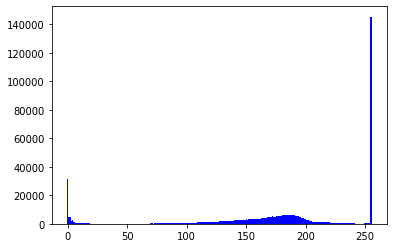

In [ ]:
plt.bar(expansion.keys(), expansion.values(), 1.0, color='b')

# **Arquivo**

In [ ]:
def load_filter_data(filter_name):
  offset = None
  kernel_stage = False
  kernel = []
  pivot = {'row': -1, 'column': -1}

  with open(filter_name, 'r') as f:
    lines = f.readlines()

    for i in lines:

      if kernel_stage and not re.search('(pivot)\=', i):
        row = list(map(float, i.split()))
        kernel.append(row)
      
      if re.search('(offset)\=',i):
        offset = int(i.split('=')[1])
      
      elif re.search('(kernel)\=', i):
        kernel_stage = True
      
      elif re.search('(pivot)\=', i):
        kernel_stage = False
        values = list(map(int, i.split('=')[1].split(',')))
        pivot['row'] = values[0]
        pivot['column'] = values[1]

  kernel = np.asarray(kernel)

  return (offset, kernel, pivot)

# **Main**

In [ ]:
os.chdir('/content/Drive/MyDrive/PDI/Masks') # Acessa o diretório da imagem
os.getcwd() # Retorna o diretório atual
os.listdir() # Lista os arquivos do diretório

['media3x3.txt',
 'media49x49.txt',
 'sobel_horizontal.txt',
 'sobel_vertical.txt']

In [ ]:
offset, mask, pivot = load_filter_data('sobel_vertical.txt')

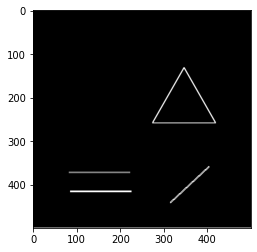

In [ ]:
image_array = np.array(image)

image_array = control_saturation(image_array, -2)

image_array = horizontal_sobel_filter(image_array, mask, offset)

plt.imshow(image_array)

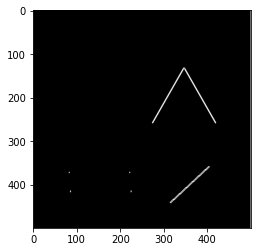

In [ ]:
image_array = np.array(image)

image_array = control_saturation(image_array, -2)

image_array = vertical_sobel_filter(image_array, mask, offset)

plt.imshow(image_array)

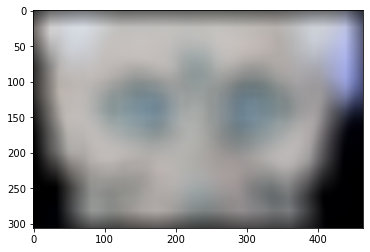

In [ ]:
image_array = np.array(image)

image_array = mean_filter(image_array,  mask, pivot, offset)

plt.imshow(image_array)

In [ ]:
offset, mask, pivot = load_filter_data('sobel_horizontal.txt')

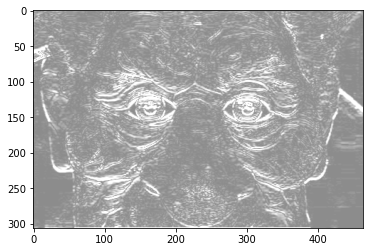

In [ ]:
'''
OFFSET SOBREL HORIZONTAL
- Descobrimos que o Offset nada mais é que uma alteração nos níveis de brilho da imagem,
  através dessa descoberta, gerenciamos o desenvolvimento da aplicação do mesmo nos filtros
'''
image_arr = np.array(image)

image_arr = control_saturation(image_arr, -2.0)

image_arr = horizontal_sobel_filter(image_arr, mask, 140) #Modificação no brilho, representando o Offset

plt.imshow(image_arr)

In [ ]:
offset, mask, pivot = load_filter_data('sobel_vertical.txt')

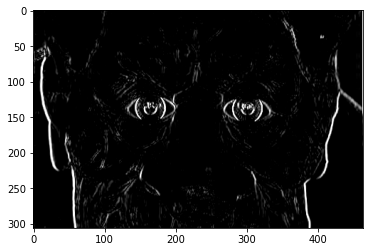

In [ ]:
'''
OFFSET SOBEL VERTICAL
'''
image_arr = np.array(image)

image_arr = control_saturation(image_arr, -2.0)

image_arr = vertical_sobel_filter(image_arr, mask, -40) #Modificação no brilho, representando o Offset

plt.imshow(image_arr)